In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = {
        "HINS1": 'HINS1_2.0',
        "HINS2": 'HINS2_2.0',
        "HINS4": 'HINS4_2.0',
        "CIT": 'CIT_1.0',
        "COW" : 'COW_1.0',
        "SCHL" : 'SCHL_16.0',
        "MAR": 'MAR_5.0',
        "SEX": 'SEX_1.0',
        "RAC1P" :'RAC1P_1.0',
        "ENG" : 'ENG_1.0',
        }
    drop_cols = []
    for i in cols:
        if cols[i] == '':
            drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
            cols[i] = drop_first
        else:
            drop_first = cols[i]
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=[i]) ; df_processed.drop(columns=drop_first, inplace=True)
    return df_processed, df, target, sex, cols

data, data_original, target, group, cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [2]:
# The details of our "example" person
cols

{'HINS1': 'HINS1_2.0',
 'HINS2': 'HINS2_2.0',
 'HINS4': 'HINS4_2.0',
 'CIT': 'CIT_1.0',
 'COW': 'COW_1.0',
 'SCHL': 'SCHL_16.0',
 'MAR': 'MAR_5.0',
 'SEX': 'SEX_1.0',
 'RAC1P': 'RAC1P_1.0',
 'ENG': 'ENG_1.0'}

### Reference Person Explanation
When encoding the discrete variables of our data. We chose the reference datapoint from Table: XX.
We chose to use this reference person as we assert this person is the "generic" american citizen in this case. <br>
| **Variable** | **Value** | **Reason** |
| --------- | -------- | --------- |
| HINS1 | 2 | As a rule, we assume that respondants don't have any form of insurance. |
| HINS2 | 2 | Same as above. |
| HINS4 | 2 | Same as above. | 
| CIT | 1 | We assume that respondants would be american-born. |
| COW | 1 | We find that working for a private for-profit company is the most "baseline" occupation. |
| SCHL | 16 | We set the reference as High school, since it fits nicely in the middle of the variable. | 
| MAR | 5 | Non-married as reference. Able to compare with the starting point in ones love life. |
| SEX | 1 | Male as reference. Slight majority in data. |
| ENG | 1 | Use very well english speaking as reference, since the country is english speaking natively.|


The overall though process for choosing the reference variables was to choose the variables which best capture the picture of the "ideal average" citizen in the dataset. <br>
We use min-max scaling on the "AGEP" variable, to ensure that our logistic regression model converges within a reasonable time-frame. <br>
In terms of model parameters we copied the Logistic regression parameters from exercise 2 and found that they work quite well for this project. The Random Forest is in initialized with 100 estimators and a max depth of 10. With these parameters we strike a balance between a lightweight tree model and still having the model be complex enough that it stays black-box. <br>


In [3]:
# Using Random Forest to Classify if target is above income threshold

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, threshold1, threshold2):
    global s1, s2, preds_s1, preds_s2, true_s1, true_s2, fpr1, tpr1, thresholds1, fpr2, tpr2, thresholds2, scores_s1, scores_s2   
    pipeline.fit(X_train, y_train)
    # y_pred = pipeline.predict(X_test)
    # Modify pipeline to fulfill one of the fairness criteria (e.g. statistical parity, equal opportunity, etc.)
    X_test = X_test.reset_index(drop=True)
    s2 = X_test.loc[X_test['SEX_2.0'] == True] 
    s1 = X_test.loc[X_test['SEX_2.0'] == False]

    true_s1 = []
    for i in s1.index:
        true_s1.append(y_test[i])
    true_s2 = []
    for i in s2.index:
        true_s2.append(y_test[i])


    scores_s1 = pipeline.predict_proba(s1)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1, pos_label=1)
    scores_s2 = pipeline.predict_proba(s2)[:, 1]
    fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2, pos_label=1)

    preds_s1 = scores_s1 > threshold1
    preds_s2 = scores_s2 > threshold2
    return pipeline

In [5]:
def minimize_odd_diff(true_s1, true_s2, scores_1, scores_2, k):
    x = np.linspace(0, 1, k)
    fpr_diff = []
    tpr_diff = []
    accuracies_1 = []
    accuracies_2 = []
    best_vals = {'threshold' : 0, 'diff' : 1}
    for idx, i in enumerate(x):
        preds_s1 = scores_1 >= i
        preds_s2 = scores_2 >= i
        tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
        tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()
        fpr1 = fp1 / (fp1 + tn1)
        tpr1 = tp1 / (tp1 + fn1)
        fpr2 = fp2 / (fp2 + tn2)
        tpr2 = tp2 / (tp2 + fn2)
        fpr_diff.append(abs(fpr1 - fpr2))
        tpr_diff.append(abs(tpr1 - tpr2))
        accuracies_1.append(accuracy_score(preds_s1, true_s1))
        accuracies_2.append(accuracy_score(preds_s2, true_s2))
        if abs(tpr_diff[idx] - fpr_diff[idx]) < abs(best_vals['diff']):
            best_vals['diff'] = abs(tpr_diff[idx] - fpr_diff[idx])
            best_vals['threshold'] = i
    return best_vals, tpr_diff, fpr_diff

In [6]:
# Needed to make sure logisric regression converges
X_train['AGEP'] = MinMaxScaler().fit_transform(X_train[['AGEP']])
X_test['AGEP'] = MinMaxScaler().fit_transform(X_test[['AGEP']])

In [7]:
rf_args = {
    'n_estimators': 100, # changed from 100
    'max_depth' : 10, #changed from 10
    'min_samples_split': 2, #changed from 2
    'min_samples_leaf': 2, #changed from 2
    'random_state': 0
}
lr_model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga", random_state=0)
p1 = RandomForestClassifier(**rf_args)
p2 = lr_model

In [8]:
p2_done = evaluate_pipeline(p2, X_train, y_train, X_test, y_test, 0.5, 0.5)

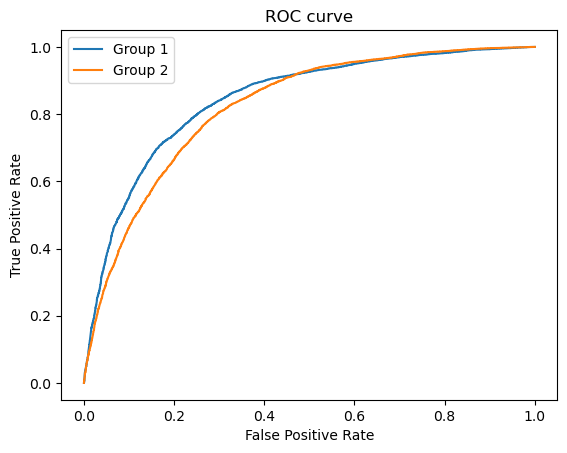

------------BEFORE BIAS ANALYSIS------------
Statistical parity:  1.241323934556354
Statistical parity:  0.8055914916015838
FPR diff:  1.091525609005854
TPR Diff 1.101014276546626
FPR diff:  0.9161489128145933
TPR Diff 0.9082534362193185
positive outcome diff: 1.1020448178636577
negative outcome diff: 0.9386142861973736
positive outcome diff: 0.9074041126009066
negative outcome diff: 1.0654003616877807
------------AFTER BIAS ANALYSIS------------
Statistical parity:  2.2647871373541717
Statistical parity:  0.44154259952581937
FPR diff:  1.112870067936324
TPR Diff 1.057810752932704
FPR diff:  0.8985774968809906
TPR Diff 0.9453486809692301
positive outcome diff: 1.931775013021031
negative outcome diff: 0.9718783920688291
positive outcome diff: 0.5176586265271841
negative outcome diff: 1.0289353155298666


In [9]:
plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('------------BEFORE BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) / np.sum(preds_s2)/len(s2)
print('Statistical parity: ', (np.sum(preds_s1)/len(s1)) /( np.sum(preds_s2)/len(s2)))
print('Statistical parity: ', (np.sum(preds_s2)/len(s2)) / (np.sum(preds_s1)/len(s1)))


tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

best_vals, balls1, balls2 = minimize_odd_diff(true_s1=true_s1, true_s2=true_s2, scores_1= scores_s1,scores_2= scores_s2, k= 1000)

# print(accuracy_score(preds_s1, true_s1))
# print(accuracy_score(preds_s2, true_s2))

preds_s1 = scores_s1 >= best_vals['threshold']
preds_s2 = scores_s2 >= best_vals['threshold']

# equalized odds (horizontal)
tpr1 = tp1 / (tp1 + fn1)
fpr1 = fp1 / (fp1 + tn1)
tpr2 = tp2 / (tp2 + fn2)
fpr2 = fp2 / (fp2 + tn2)

print('FPR diff: ', fpr1 / fpr2)
print('TPR Diff', tpr1 / tpr2)
print('FPR diff: ', fpr2 / fpr1)
print('TPR Diff', tpr2 / tpr1)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome diff:', some_1 / some_2)
print('negative outcome diff:', some_3 / some_4)

print('positive outcome diff:', some_2 / some_1)
print('negative outcome diff:', some_4 / some_3)

print('------------AFTER BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) / np.sum(preds_s2)/len(s2)
print('Statistical parity: ', (np.sum(preds_s1)/len(s1)) /( np.sum(preds_s2)/len(s2)))
print('Statistical parity: ', (np.sum(preds_s2)/len(s2)) / (np.sum(preds_s1)/len(s1)))

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
fpr_group1 = fp1 / (fp1 + tn1)
tpr_group1 = tp1 / (tp1 + fn1)

tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()
fpr_group2 = fp2 / (fp2 + tn2)
tpr_group2 = tp2 / (tp2 + fn2)

# equalized odds (horizontal)
print('FPR diff: ', fpr_group1 / fpr_group2)
print('TPR Diff', tpr_group1 / tpr_group2)
print('FPR diff: ', fpr_group2 / fpr_group1)
print('TPR Diff', tpr_group2 / tpr_group1)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome diff:', some_1 / some_2)
print('negative outcome diff:', some_3 / some_4)

print('positive outcome diff:', some_2 / some_1)
print('negative outcome diff:', some_4 / some_3)

# print(accuracy_score(preds_s1, true_s1))
# print(accuracy_score(preds_s2, true_s2))

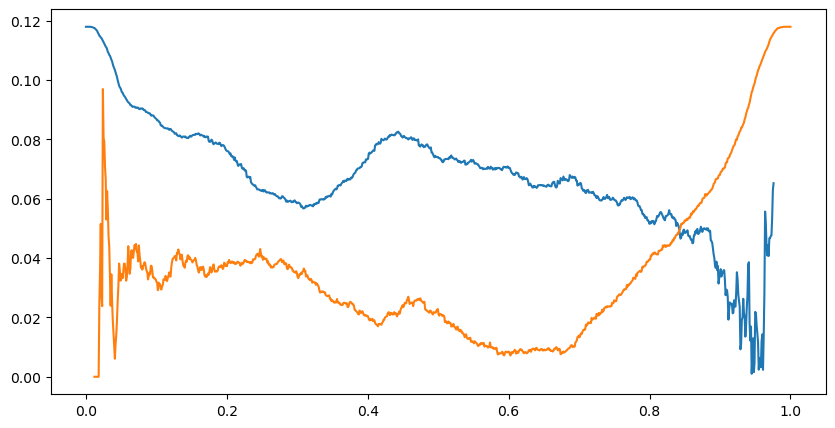

In [10]:
plt.figure(1, figsize=(10, 5))
plt.plot(np.linspace(0, 1, 1000),balls1, label = 'tpr_diff')
plt.plot(np.linspace(0, 1, 1000), balls2, label = 'fpr_diff')

In [11]:
p1_done = evaluate_pipeline(p1, X_train, y_train, X_test, y_test, 0.5, 0.5)

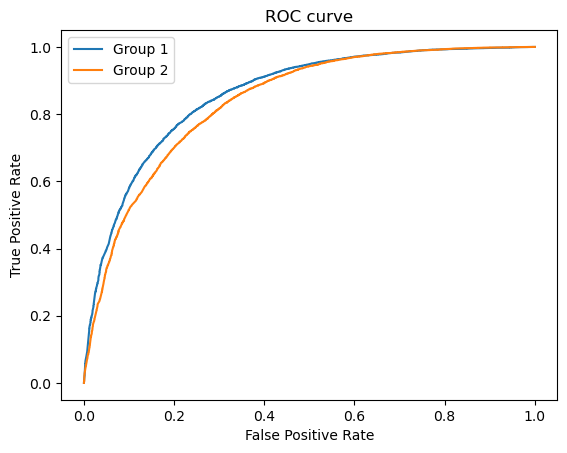

------------BEFORE BIAS ANALYSIS------------
Statistical parity:  1.0904081915073554
Statistical parity:  0.9170877546486724
FPR diff:  1.351303468026115
TPR Diff 1.1483541871490015
FPR diff:  0.7400262218380351
TPR Diff 0.8708114719228588
positive outcome diff: 1.0096855494379604
negative outcome diff: 1.040324146114147
positive outcome diff: 0.9904073605457147
negative outcome diff: 0.96123886361307
------------AFTER BIAS ANALYSIS------------
Statistical parity:  1.6468251224995796
Statistical parity:  0.607229016813991
FPR diff:  1.1117967545978598
TPR Diff 1.0487731849914115
FPR diff:  0.8994449712723824
TPR Diff 0.9534950114196418
positive outcome diff: 1.3926764616258291
negative outcome diff: 0.9616016023653965
positive outcome diff: 0.7180418622373976
negative outcome diff: 1.03993171136586


In [12]:
plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('------------BEFORE BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) / np.sum(preds_s2)/len(s2)
print('Statistical parity: ', (np.sum(preds_s1)/len(s1)) /( np.sum(preds_s2)/len(s2)))
print('Statistical parity: ', (np.sum(preds_s2)/len(s2)) / (np.sum(preds_s1)/len(s1)))


tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

best_vals, balls1, balls2 = minimize_odd_diff(true_s1=true_s1, true_s2=true_s2, scores_1= scores_s1,scores_2= scores_s2, k= 1000)

# print(accuracy_score(preds_s1, true_s1))
# print(accuracy_score(preds_s2, true_s2))

preds_s1 = scores_s1 >= best_vals['threshold']
preds_s2 = scores_s2 >= best_vals['threshold']

# equalized odds (horizontal)
tpr1 = tp1 / (tp1 + fn1)
fpr1 = fp1 / (fp1 + tn1)
tpr2 = tp2 / (tp2 + fn2)
fpr2 = fp2 / (fp2 + tn2)

print('FPR diff: ', fpr1 / fpr2)
print('TPR Diff', tpr1 / tpr2)
print('FPR diff: ', fpr2 / fpr1)
print('TPR Diff', tpr2 / tpr1)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome diff:', some_1 / some_2)
print('negative outcome diff:', some_3 / some_4)

print('positive outcome diff:', some_2 / some_1)
print('negative outcome diff:', some_4 / some_3)

print('------------AFTER BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) / np.sum(preds_s2)/len(s2)
print('Statistical parity: ', (np.sum(preds_s1)/len(s1)) /( np.sum(preds_s2)/len(s2)))
print('Statistical parity: ', (np.sum(preds_s2)/len(s2)) / (np.sum(preds_s1)/len(s1)))

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
fpr_group1 = fp1 / (fp1 + tn1)
tpr_group1 = tp1 / (tp1 + fn1)

tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()
fpr_group2 = fp2 / (fp2 + tn2)
tpr_group2 = tp2 / (tp2 + fn2)

# equalized odds (horizontal)
print('FPR diff: ', fpr_group1 / fpr_group2)
print('TPR Diff', tpr_group1 / tpr_group2)
print('FPR diff: ', fpr_group2 / fpr_group1)
print('TPR Diff', tpr_group2 / tpr_group1)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome diff:', some_1 / some_2)
print('negative outcome diff:', some_3 / some_4)

print('positive outcome diff:', some_2 / some_1)
print('negative outcome diff:', some_4 / some_3)

# print(accuracy_score(preds_s1, true_s1))
# print(accuracy_score(preds_s2, true_s2))

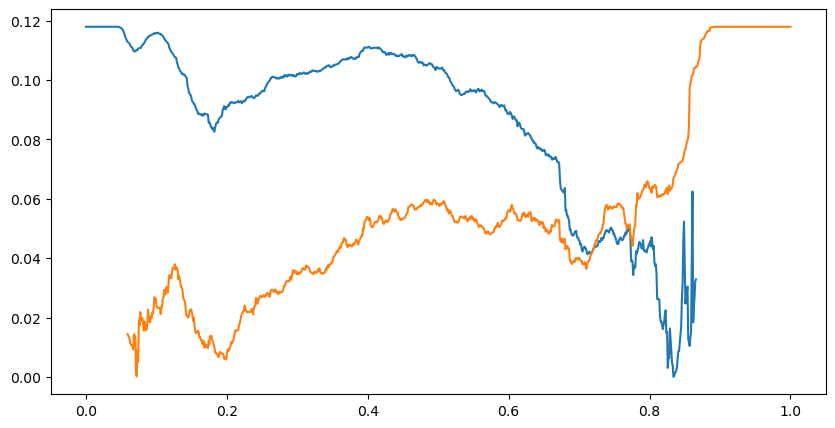

In [13]:
plt.figure(1, figsize=(10, 5))
plt.plot(np.linspace(0, 1, 1000),balls1, label = 'tpr_diff')
plt.plot(np.linspace(0, 1, 1000), balls2, label = 'fpr_diff')

### Changes to be made to models
The accuracy of the classifier sits at 0.77 as of baseline test with the selected pipeline. Standard-scaling was used across all features, which may end up causing trouble. The model has a fairly high accuracy for a baseline classifier, with desirable f1-scores at [0.72, 0.81]. Since the outcome variable in this case is almost equally balanced at the chosen threshold, we need not to scale our model much with respect to the outcome variable. In this pipeline discrete variables are scaled, which changes the otherwise explainable binary variables, which hurts the explainability of the model. <br>
<br>
We would need to only scale the age column in the data to fix this explainability issue. Unless we had more continuous ways of representing the discrete variables in the data (such as language test scores for english proficiency, SAT scores for education etc.) we would not be able to quantify these columns in any meaningful fashion.

### What we did
In trying to improve the interpretability of our model, we limit the scaling to exclusively be applied to the "AGEP" column, seeing as it is the only continuous variable in the data. We also use the template's onehot-encodings applied to the discrete variables, with dropping the first value applied. This way we can compare each categorical variable to the baseline of the one which is dropped. <br>

Before making any changes to any of the models we find the following accuracies of the classifiers: 
<br>
(insert classification report for models)
<br>



### Scores affected by Equalized outcome
In fine-tuning the thresholds for our models to obtain statistical parity, we found that we had to sacrifice model accuracy on Group 1 (Males), to equalize the outcome accuracy. This meant we had to choose a suboptimal threshold for Group 1 and chose the best Threshold for Group 2. When applying this to the logistic regression model, we found that changing the thresholds obtained equalized outcomes within ~1 percent difference, this threshold change also moved the model closer to obtaining equalized odds, with only a ~2 percent difference. <br>
<br>
When applying this method to the Blackbox Random Forest. 

## Task 3: Model agnostic explainations with SHAP

Here we use model agnostic explainations with SHAP to explain both of the models. To summarize the sections are:

 - Row chosen for comparison and printed
 - For Logistic Regression and then Random Forest after:
    1. Calculate SHAP values
    2. Generate bar plot
    3. Generate beeswarm plot
    4. Generate force plot for specific row
    5. Generate force plot for specific row with aggregated one-hot encodings

## Rows chosen for comparison

In [15]:
# ended up just choosing row 0 for simplicity - so we have a legacy naming convention
specific_rows = [0]

In [16]:
X_test.iloc[[0]]

,AGEP,HINS1_1.0,HINS1_nan,HINS2_1.0,HINS2_nan,HINS4_1.0,HINS4_nan,CIT_2.0,CIT_3.0,CIT_4.0,...,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
309375,0.584416,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## Generating the plots

### Logistic Regression plots

Calculating SHAP values...
Generating general bar plot...


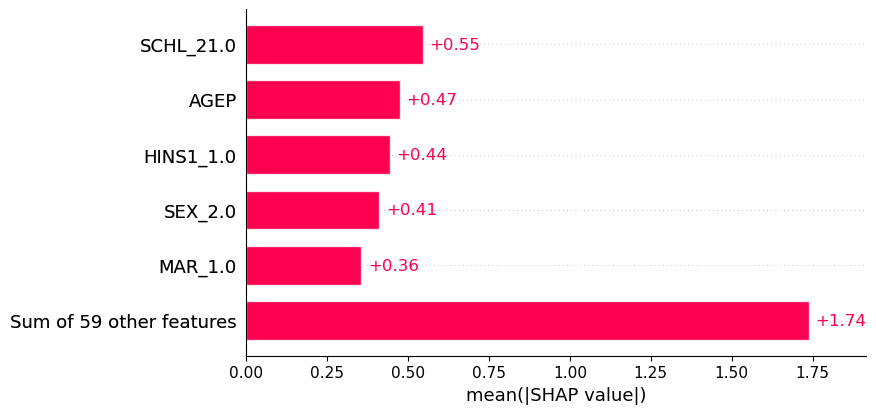

Generating general beeswarm plot...


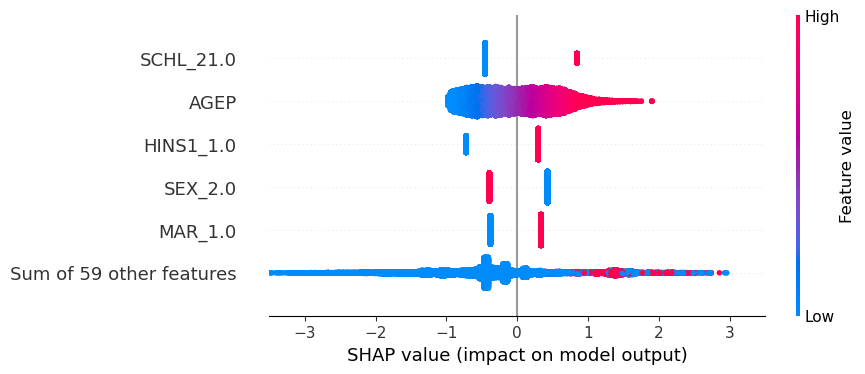

Generating row specific plots...
Row 0


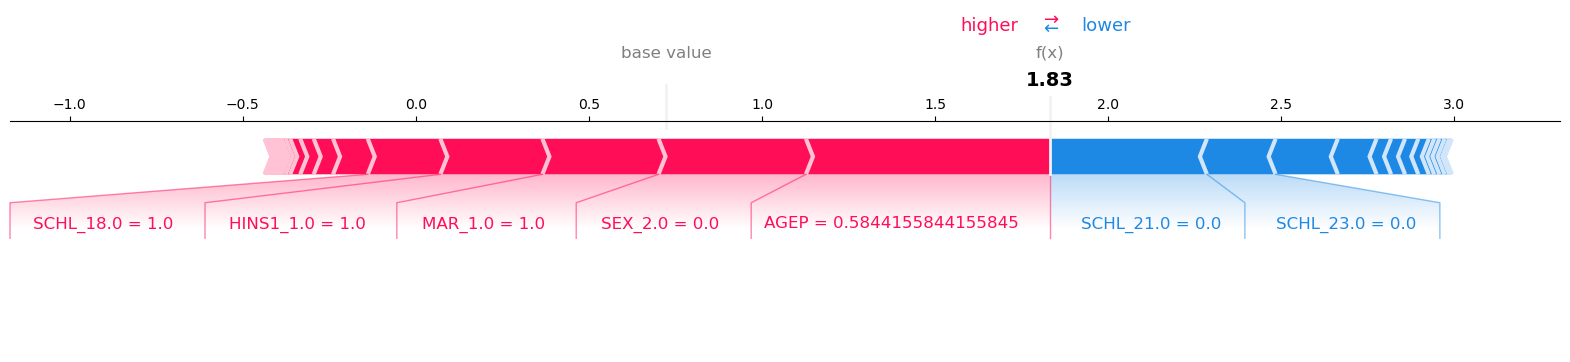

In [17]:
print('Calculating SHAP values...')
X_train_ = X_train.to_numpy().astype(float)
X_test_ = X_test.to_numpy().astype(float)
lr_explainer = shap.Explainer(
    p2,
    X_train_,
    # model_output='probability',
    # link=shap.links.logit,
    # algorithm='linear',
    feature_names=X_train.columns
    )

lr_shap_values = lr_explainer(X_test_)

print('Generating general bar plot...')
shap.plots.bar(lr_shap_values, max_display=6)

print('Generating general beeswarm plot...')
shap.plots.beeswarm(lr_shap_values, max_display=6, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-3.5, 3.5) 
plt.show()

print('Generating row specific plots...')
for i in specific_rows:
    print(f'Row {i}')
    # shap.force_plot(shap_values[i], link='logit', matplotlib=True)
    shap.force_plot(lr_shap_values[i], matplotlib=True)

Generating row specific plots with aggregated categories...
Row 0


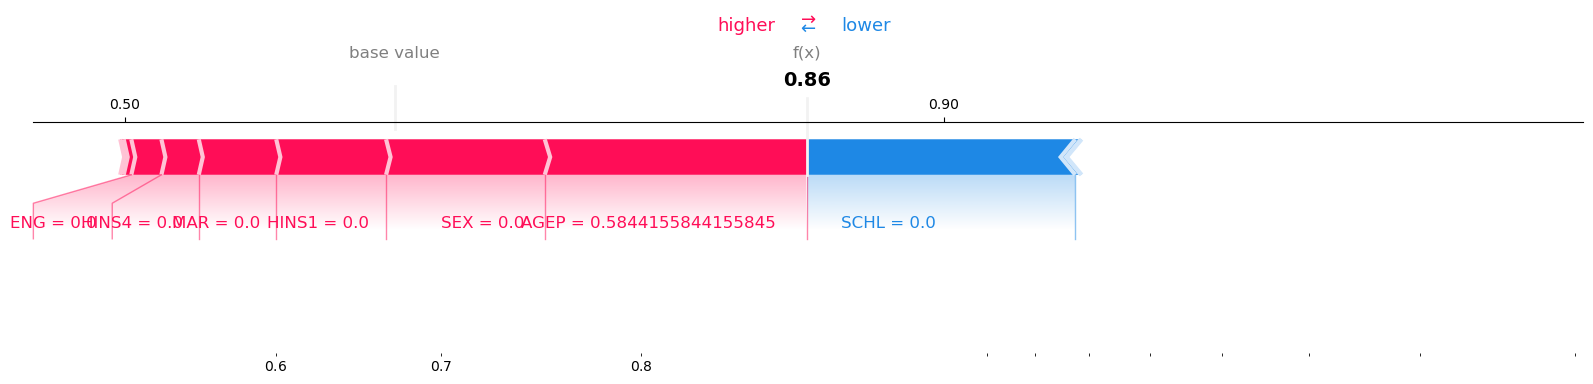

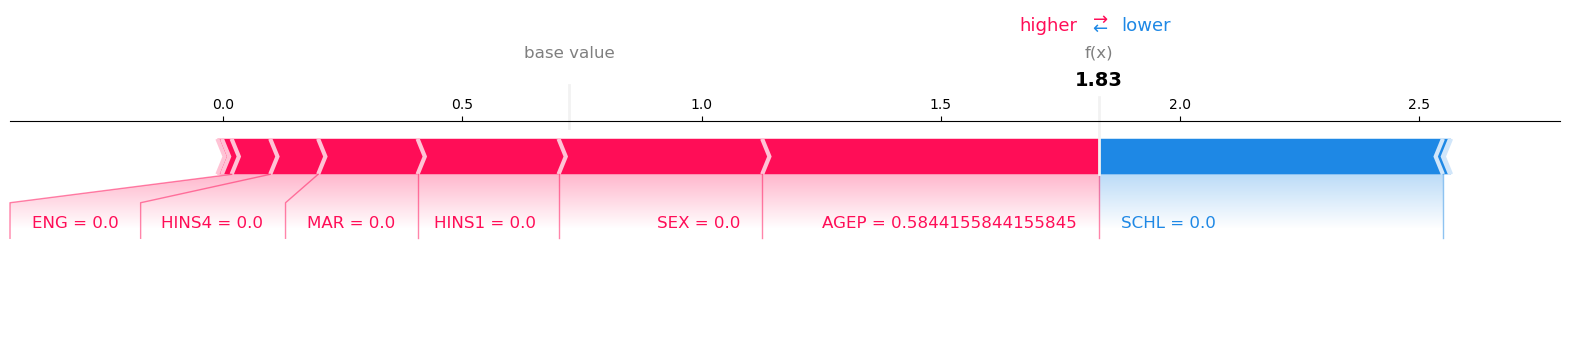

In [18]:
group_idx = list()
shap_agg_full = np.zeros((lr_shap_values.shape[0], len(X_train.columns)))
for i in feature_names:
    group_idx.append([n for n, l in enumerate(X_train.columns) if l.startswith(i)])

# group_idx now contains the indices of the features that belong to each group
# we can now sum the SHAP values for each group
    
for ii, g in enumerate(group_idx):
    shap_agg_full[:, ii] = np.sum(lr_shap_values[:, g].values, -1)

# copy and replace? - YES
lr_shap_values_copy = lr_shap_values
lr_shap_values_copy.values = shap_agg_full

# now can do the force plots again
print('Generating row specific plots with aggregated categories...')
for i in specific_rows:
    print(f'Row {i}')
    # shap.force_plot(shap_values[i], link='logit', matplotlib=True)
    shap.force_plot(lr_shap_values_copy[i], feature_names=feature_names, matplotlib=True, link='logit')
    shap.force_plot(lr_shap_values_copy[i], feature_names=feature_names, matplotlib=True)

### Random Forest Plots

In [19]:
print('Calculating SHAP values... can take up to 15 mins...')
X_train_ = X_train.to_numpy().astype(float)
X_test_ = X_test.to_numpy().astype(float)
rf_explainer = shap.Explainer(p1, X_train_, model_output='probability', feature_names=X_train.columns)
rf_shap_values = rf_explainer(X_test_)

Calculating SHAP values... can take up to 15 mins...


100%|===================| 78191/78266 [11:11<00:00]        

Generating general bar plot...


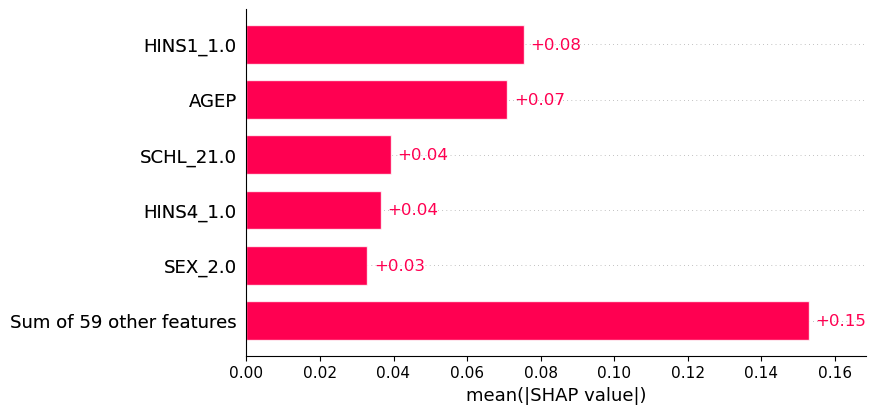

In [20]:
print('Generating general bar plot...')
shap.plots.bar(rf_shap_values[:,:,1], max_display=6)

Generating general beeswarm plot...


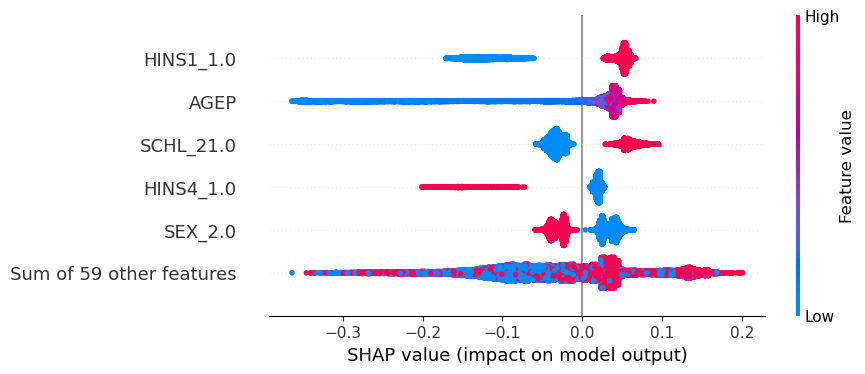

In [21]:
print('Generating general beeswarm plot...')
shap.plots.beeswarm(rf_shap_values[:,:,1], max_display=6)

# unused scaling:
# ax = plt.gca()
# # You can change the min and max value of xaxis by changing the arguments of:
# ax.set_xlim(-3.5, 3.5)
# plt.show()

Generating row specific plots...
Row 0


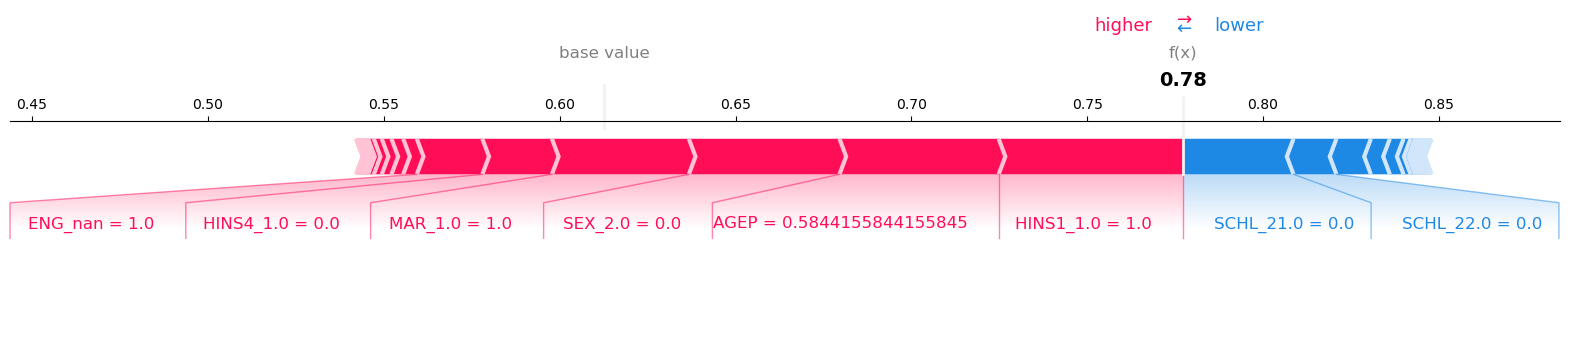

In [22]:
print('Generating row specific plots...')
for i in specific_rows:
    print(f'Row {i}')
    row_to_explain = X_test_[i]
    row_shap_values = rf_explainer(row_to_explain)
    shap.plots.force(rf_explainer.expected_value[1], row_shap_values.values[:,1], row_to_explain, feature_names=X_train.columns, matplotlib=True)

Generating row specific plots with aggregated categories...
Row 0


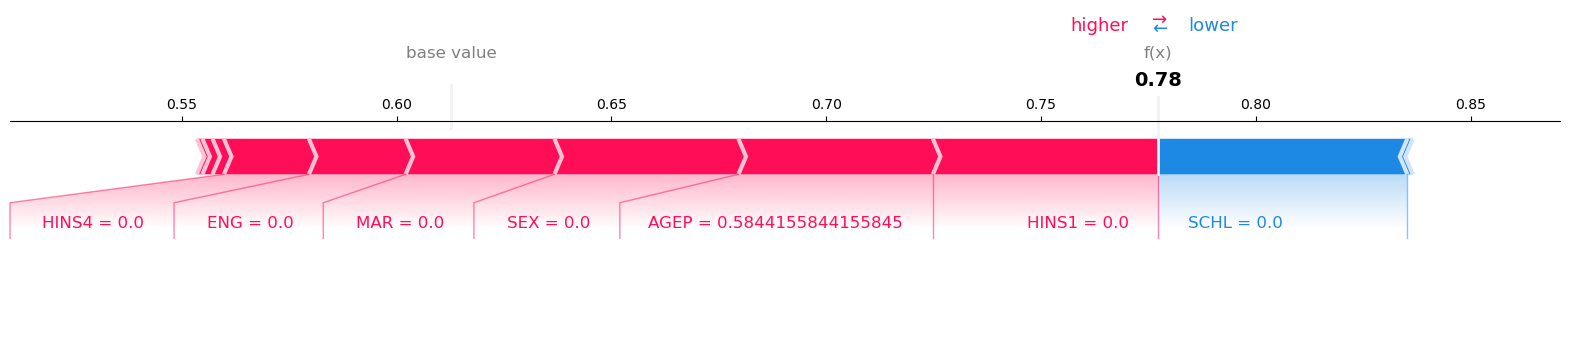

In [23]:
print('Generating row specific plots with aggregated categories...')
for i in specific_rows:
    print(f'Row {i}')
    
    row_to_explain = X_test_[i]
    row_shap_values = rf_explainer(row_to_explain)
    
    group_idx = list()
    shap_agg_row = np.zeros((row_shap_values.shape[0], 2))
    
    for i in feature_names:
        group_idx.append([n for n, l in enumerate(X_train.columns) if l.startswith(i)])

    for idx, g in enumerate(group_idx):
        shap_agg_row[idx, 1] = np.sum(row_shap_values[g, 1].values, -1)

    row_shap_values_copy = row_shap_values
    row_shap_values_copy.values = shap_agg_row

    shap.plots.force(rf_explainer.expected_value[1], row_shap_values.values[:,1], row_to_explain, feature_names=feature_names, matplotlib=True)

### Who is the 0th index?

- 62
- Male
- Some College, but less than 1 year
- They have insurance through a current or former employer or union